# Investigate binned maps 

In [1]:
## First import general packages for running python analysis:
import os, h5py, datetime,pytz
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import pickle, glob, yaml, string

from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares
from scipy.stats import binned_statistic_2d

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals import beammap as bp
import beamcals.beam_autoprocessing as ba
from beamcals.sites import site
import beamcals.reduce_ccclass as rc

gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')

# various gridding attempts
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)

fitdir='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
ymldir = '/hirax/GBO_Analysis_Outputs/concat_config_files/'
pckldir = '/hirax/GBO_Analysis_Outputs/flight_pickles/'
ampdir = '/hirax/GBO_Analysis_Outputs/amplitude_corrections/'
beamdir = '/hirax/GBO_Analysis_Outputs/beam_pickles/'

In [2]:
def get_flightinfo(fly):
    for fi in range(0,len(documents["flight_info"]["flights"])):
        if fly == flights[fi]: f = fi
    
    if polarn[f]=='N':
        pols = N_pols
        cpols = E_pols
    else:
        pols = E_pols
        cpols = N_pols
    return polarn[f], pols, cpols, attns[f], f

def get_beam_diff(beam2, beam1,n):
    return beam2[:,:] - n*beam1[:,:]

def get_stat(new_d,whstat='stddev'): # default is stddev
    diff_flat = np.ndarray.flatten(new_d)
    if whstat=='stddev':
        stat = np.nanstd(diff_flat)
    elif whstat=='median':
        # compute median
        stat = np.abs(np.nanmedian(diff_flat))
    elif whstat=='sum':
        stat = np.nanmean(np.abs(diff_flat))
    elif whstat=='mednoabs':
        stat = np.nanmedian(diff_flat)
    return stat

def get_slice(beam,Z,val,ax='x'):
    # this gradually increases the tolerance until it finds something
    tol = abs(beam.x_centers_grid[0,1,0] - beam.x_centers_grid[0,0,0])/1.5
    N = len(beam.x_centers_grid[0,:,0])
    ok = True
    while(ok):
        if ax=='x':
            col = np.where((beam.x_centers_grid[0,:,0] < val+tol) & (beam.x_centers_grid[0,:,0] > val-tol))[0][0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        if ax=='y':
            col = np.where((beam.y_centers_grid[:,0,0] < val+tol) & (beam.y_centers_grid[:,0,0] > val-tol))[0][0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        tol+=3
        if tol > 30: ok = False
    return col

def get_slice_anyin(LX,LY,val,ax='x'):
    tol = abs(LX[0,1] - LX[0,0])/1.5
    if ax=='x':
        col = np.where((LX[0,:] < val+tol) & (LX[0,:] > val-tol))[0][0]
    if ax=='y':
        col = np.where((LY[:,0] < val+tol) & (LY[:,0] > val-tol))[0][0]
    return col


def get_concatlist(flights):
    #for i, fly in enumerate(flights):
    pickle_directory='/hirax/GBO_Analysis_Outputs/flight_pickles/'
    concytest=[glob.glob(pickle_directory+'*'+fly+'*')[0] for fly in flights]
    return concytest

In [3]:
################################################################################################
######## 1. Read in some particular frequency, polarization 2D co-added beam ################
################################################################################################

with open('/home/ln267/newburghlabdrone/analysis/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]
polarn = documents["flight_info"]["pols"]
attns = documents["flight_info"]["attns"]
masks = documents["flight_info"]["masks"]
good_freqs = documents["freq_info"]["good_freqs"]

pcklarr=np.sort(os.listdir(pckldir))
gfitarr=np.sort(os.listdir(fitdir))
amparr=np.sort(os.listdir(ampdir))
print(gfitarr,amparr)


# SLICE DEFAULTS # 
sliw = 10 # This defines slices for (some) plots
sz = 80 # use this to set the size of the Xargs and Yargs for beammapping, usually 80 or 50

# PLOTTING DEFAULT # 
cmap = matplotlib.cm.get_cmap('gnuplot2')
norm = matplotlib.colors.Normalize(vmin=-25, vmax=25)
sfig = False

Npolflights = ['618','619','625','646','647','533','536']
Epolflights = ['620','648','649','535']




['FLY533_20210826T182904Z_2dGauss_and_Airy_Params.npz'
 'FLY534_20210826T185621Z_2dGauss_and_Airy_Params.npz'
 'FLY535_20210826T192056Z_2dGauss_and_Airy_Params.npz'
 'FLY536_20210826T195003Z_2dGauss_and_Airy_Params.npz'
 'FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz'
 'FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz'
 'FLY620_20211021T192212Z_2dGauss_and_Airy_Params.npz'
 'FLY623_20211021T203206Z_2dGauss_and_Airy_Params.npz'
 'FLY625_20211021T214028Z_2dGauss_and_Airy_Params.npz'
 'FLY646_20211022T183659Z_2dGauss_and_Airy_Params.npz'
 'FLY647_20211022T185749Z_2dGauss_and_Airy_Params.npz'
 'FLY648_20211022T191922Z_2dGauss_and_Airy_Params.npz'
 'FLY649_20211022T194308Z_2dGauss_and_Airy_Params.npz'] ['FLY533_Corrected_amplitudes.pkl' 'FLY534_Corrected_amplitudes.pkl'
 'FLY535_Corrected_amplitudes.pkl' 'FLY536_Corrected_amplitudes.pkl'
 'FLY618_Corrected_amplitudes.pkl' 'FLY619_Corrected_amplitudes.pkl'
 'FLY620_Corrected_amplitudes.pkl' 'FLY623_Corrected_amplitudes.pkl'
 'FLY625

In [4]:
# pick your polarization and frequency

print(good_freqs)

# set which pol:
copoldir = 'N'
pols = N_pols
find = good_freqs[0]
f_intern = 0 # only one frequency per file, this is always 0

[538, 553, 554, 555, 556, 557, 558, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 571, 572, 573, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 599, 630, 631, 633, 645, 676, 691, 692, 693, 696, 697, 698, 699, 700, 705, 707, 720, 768, 799, 807, 814, 845, 846, 848, 849, 850, 851, 854, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 871, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 887, 888, 889, 890, 891, 893, 894, 895, 896, 897, 898, 900, 901, 902, 903, 904, 905, 906, 907, 908, 910, 911, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 935, 938]


<ipython-input-5-3c8ed9a77650>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],


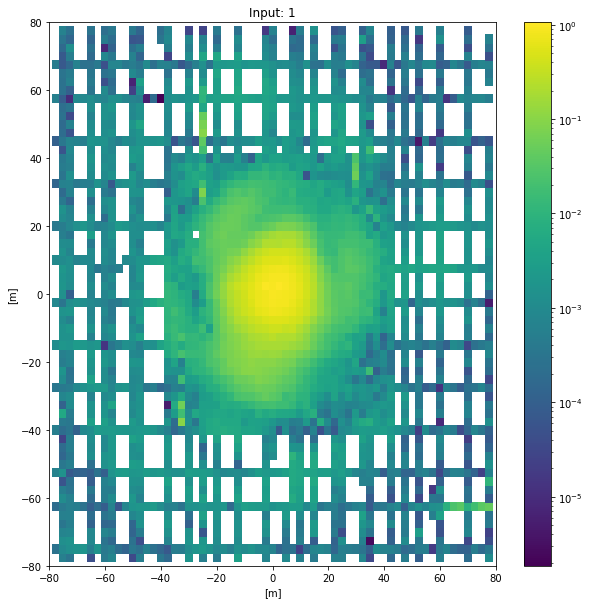

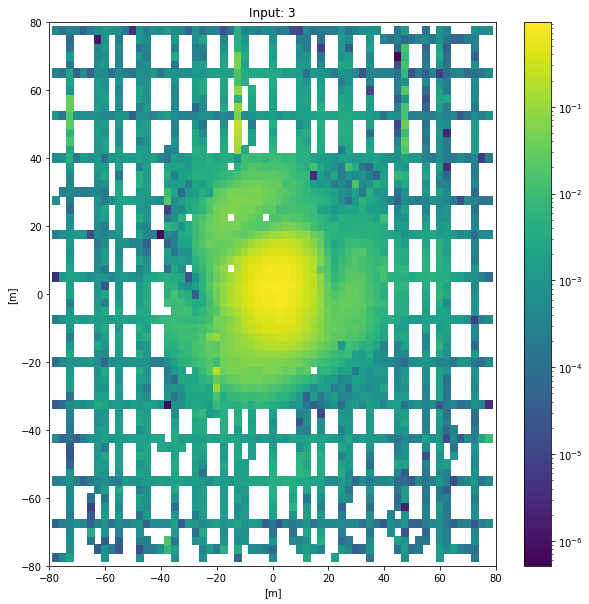

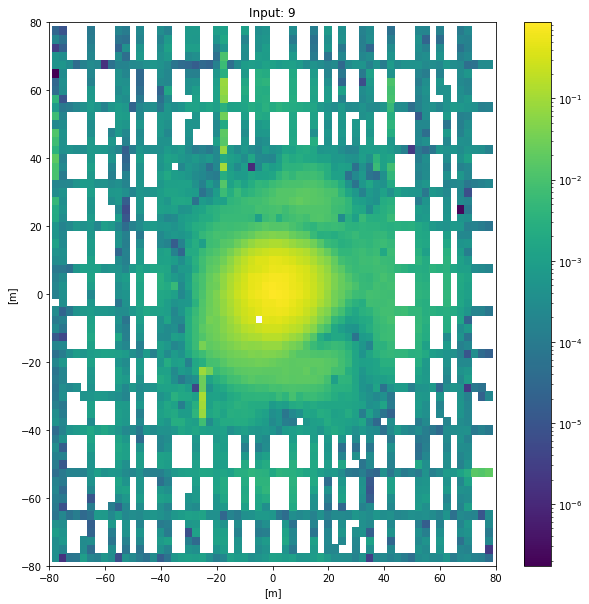

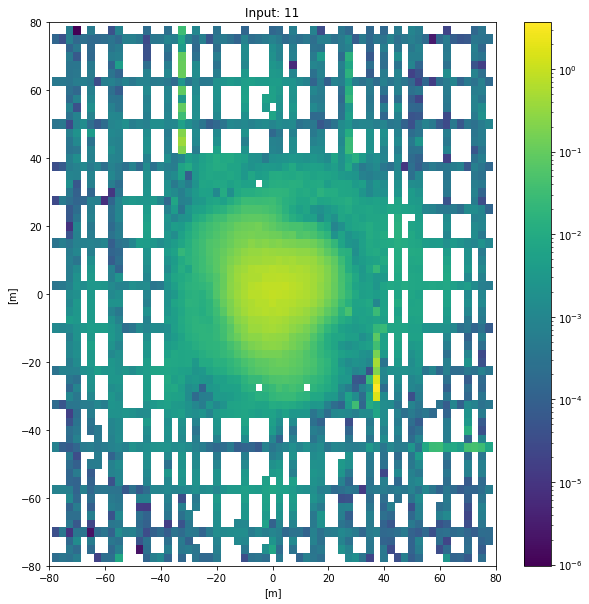

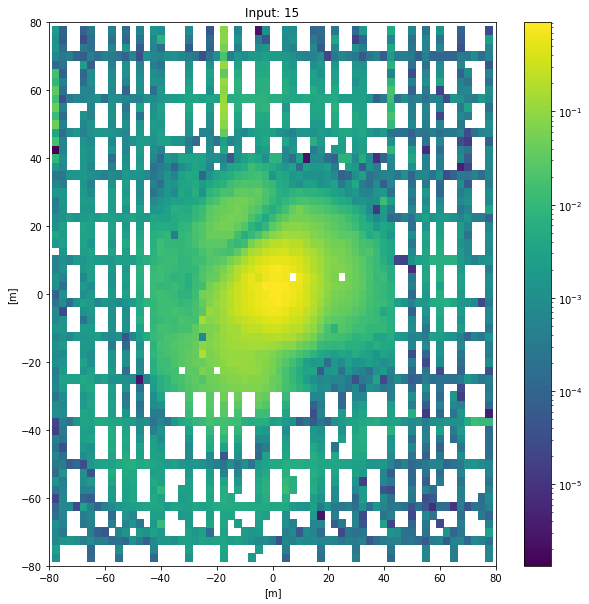

<ipython-input-5-3c8ed9a77650>:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],


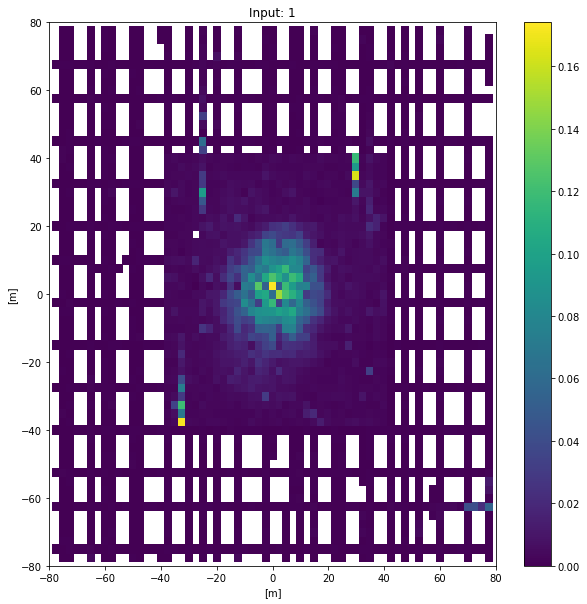

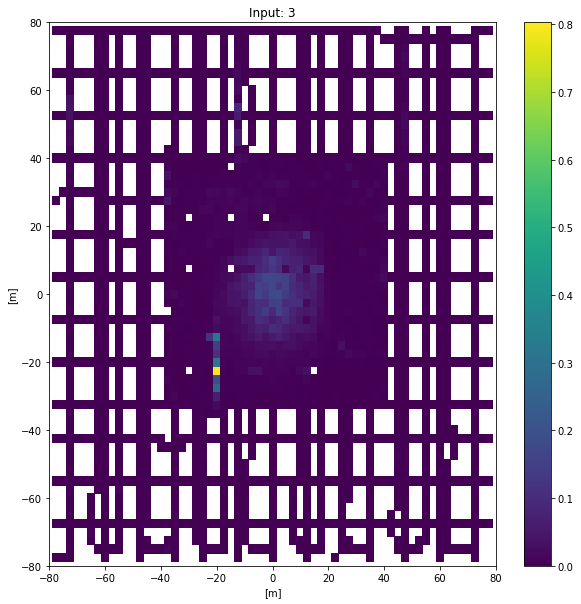

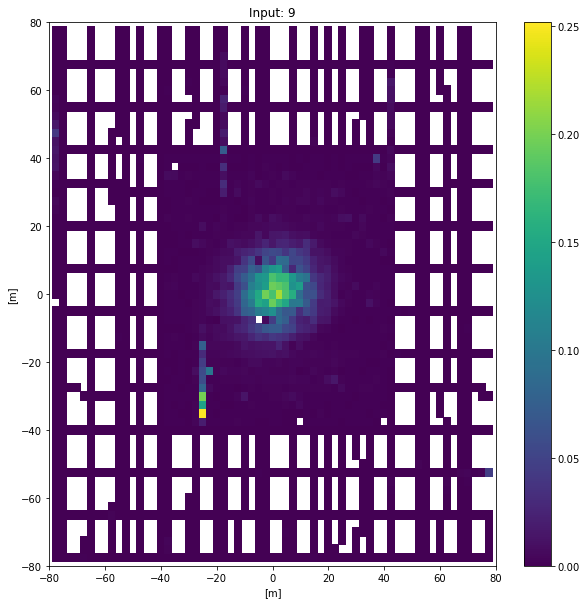

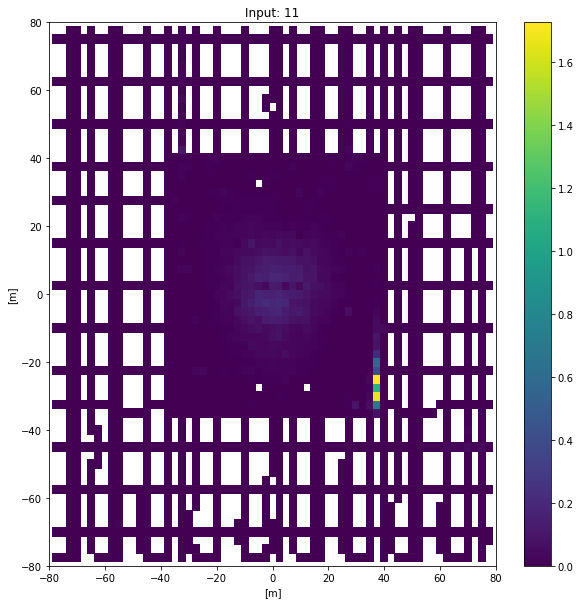

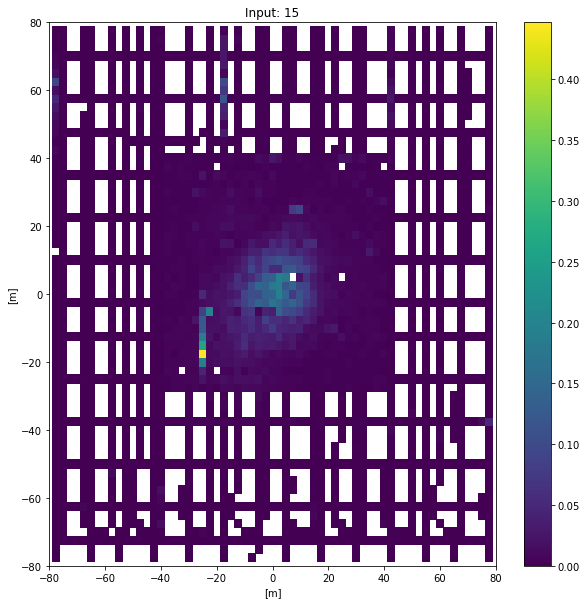

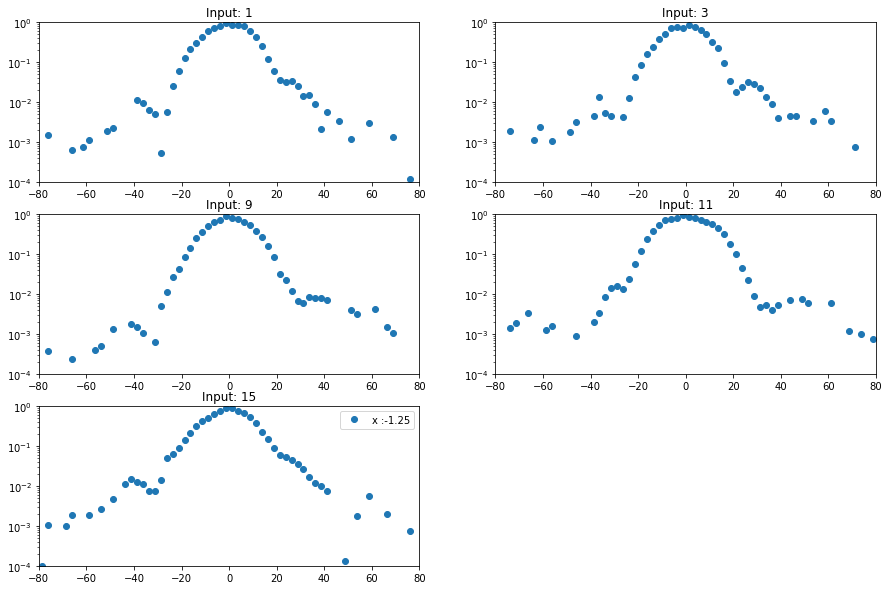

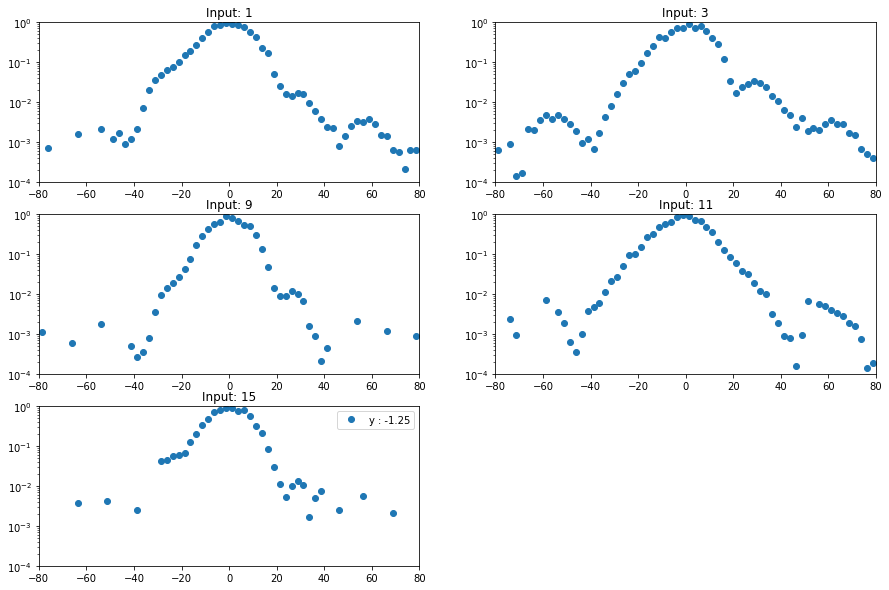

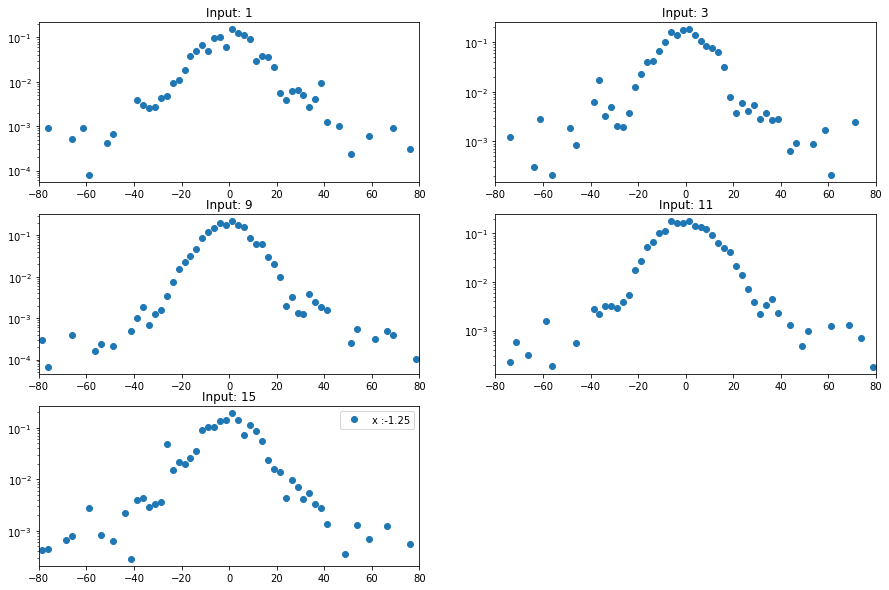

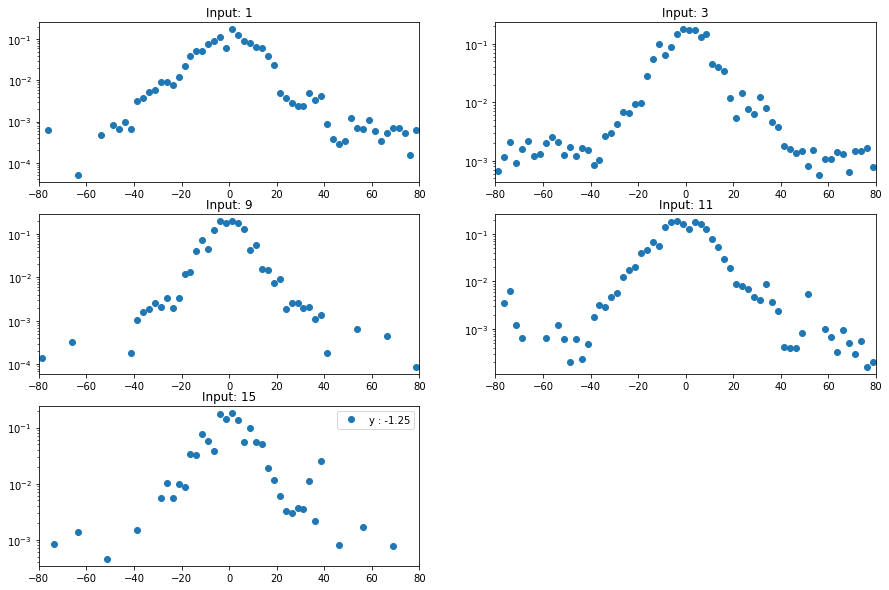

In [5]:
# read in the pickle beam file and plot some things

picklefile = beamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'.pkl'
with open(picklefile, 'rb') as inp:
    ptest = pickle.load(inp)
    
# Plot maps and variances

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],
               np.abs(ptest.V_LC_operation[:,:,0,chind]),cmap=cm.viridis,norm=LogNorm())#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()

for i,chind in enumerate(pols):
    fig = plt.figure(figsize=(10,10))
    plt.pcolormesh(ptest.x_centers_grid[:,:,chind],ptest.y_centers_grid[:,:,chind],
               ptest.V_LC_operation_err[:,:,0,chind],cmap=cm.viridis)#,edgecolors='k')
    plt.xlim(-1*sz,sz)
    plt.ylim(-1*sz,sz)
    plt.xlabel('[m]')
    plt.ylabel('[m]')
    plt.title('Input: '+str(chind))
    plt.colorbar()
    plt.show()
    
    
# Plot slices
# MAPPS ::: take slice at x = 0
xx = 0
colx = get_slice(ptest,ptest.V_LC_operation[:,:,0,chind],xx,'x')

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(pols):
    plt.subplot(3,2,j+1) 
    plt.semilogy(ptest.y_centers_grid[:,colx,0],ptest.V_LC_operation[colx,:,0,chind].T,'o',
             label='x :'+str(ptest.x_centers_grid[0,colx,0]))
    plt.title('Input: '+str(chind))
    plt.ylim(0.0001,1)
    plt.xlim(-1*sz,sz)
plt.legend()
plt.show()

xx = 0
coly = get_slice(ptest,ptest.V_LC_operation[:,:,0,chind],xx,'y')
fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(pols):
    plt.subplot(3,2,j+1)
    plt.semilogy(ptest.x_centers_grid[coly,:,0],ptest.V_LC_operation[:,coly,0,chind].T,'o',
             label='y : '+str(ptest.y_centers_grid[coly,0,0]))
    plt.ylim(0.0001,1)
    plt.xlim(-1*sz,sz)
    plt.title('Input: '+str(chind))
plt.legend()
plt.show()

# ERRORS:::: take slice at x = 0
xx = 0
colx = get_slice(ptest,ptest.V_LC_operation[:,:,0,chind],xx,'x')

fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(pols):
    plt.subplot(3,2,j+1) 
    plt.semilogy(ptest.y_centers_grid[:,colx,0],(ptest.V_LC_operation_err[colx,:,0,chind].T),'o',
             label='x :'+str(ptest.x_centers_grid[0,colx,0]))
    plt.title('Input: '+str(chind))
    #plt.ylim(0.0001,1)
    plt.xlim(-1*sz,sz)
plt.legend()
plt.show()

xx = 0
coly = get_slice(ptest,ptest.V_LC_operation[:,:,0,chind],xx,'y')
fig = plt.figure(figsize=(15,10))
for j, chind in enumerate(pols):
    plt.subplot(3,2,j+1)
    plt.semilogy(ptest.x_centers_grid[coly,:,0],ptest.V_LC_operation_err[:,coly,0,chind].T,'o',
             label='y : '+str(ptest.y_centers_grid[coly,0,0]))
    #plt.ylim(0.0001,1)
    plt.xlim(-1*sz,sz)
    plt.title('Input: '+str(chind))
plt.legend()
plt.show()

In [6]:
################################################################################################
################## 2. Fit a 2D Gaussian to the data set #################################
################################################################################################


In [14]:
# set up initial conditions
# [amp, x cent, x sigma, y cent, ysigma, background offset]
amp0 = 1.0
x00 = 0.0
y00 = 0.0
xsig0 = 8.0
ysig0 = 8.0
bg0 = 0.0
pG=np.array([amp0,x00,xsig0,y00,ysig0,bg0])

chind = pols[0]

mbx = ptest.x_centers_grid[:,:,0].flatten()
mby = ptest.y_centers_grid[:,:,0].flatten()
mbV = ptest.V_LC_operation[:,:,0,chind].flatten()
gooddata = np.isfinite(mbV)
input_data=np.array([mbx[gooddata],mby[gooddata],mbV[gooddata]])
## run the fits:
G_popt=least_squares(fu.Gauss_2d_LC_opt,x0=pG,method='trf',args=input_data).x
print(G_popt) # best fit parameters, ordered in the same as above [amp, etc]

[ 9.87493534e-01  8.61265545e-02  8.69242060e+00 -5.51352240e-02
  8.61029744e+00  3.38898138e-03]


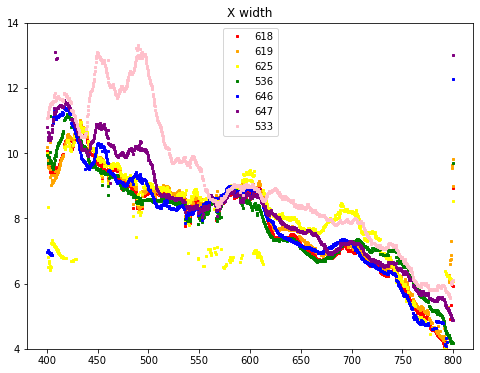

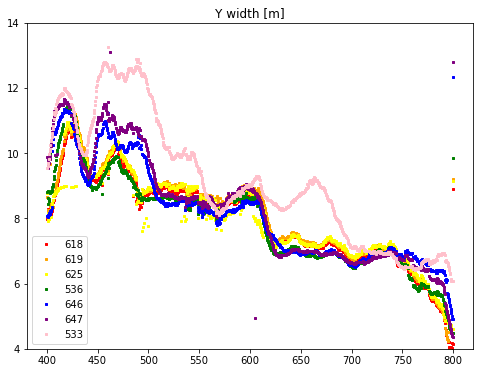

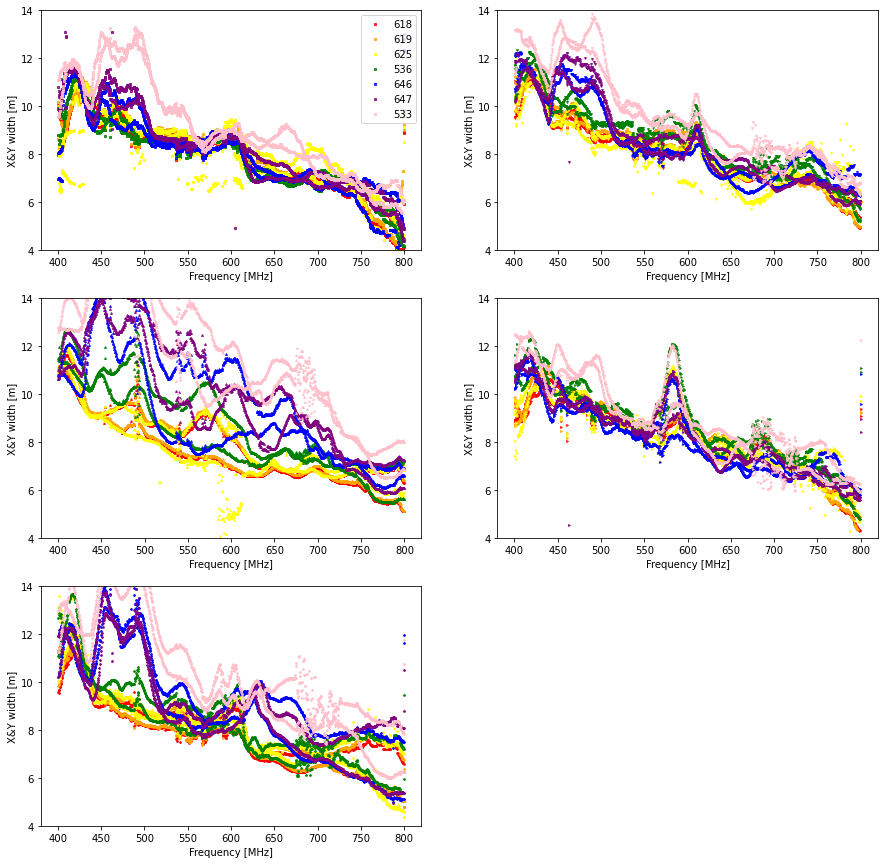

In [16]:
################################################################################################
################# 3. Compare to the combination of individual flights #####################
################################################################################################

## N pol flights

flies = ['618','619','625','536','646', '647','533']
pols = N_pols
markers = ['s','v','^','>','P','x','+','o']
colors=['red','orange','yellow','green','blue','purple','pink']
p = 0

# X width
fig = plt.figure(figsize=(8,6))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    #for p in range(0,len(pols)):
    plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],linestyle='None',label=fly)
plt.title('X width')
plt.legend()
plt.ylim(4,14)
plt.show()

# Y width
fig = plt.figure(figsize=(8,6))
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    #for p in range(0,len(pols)):
    plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],linestyle='None',label=fly)
plt.title('Y width [m]')
plt.legend()
plt.ylim(4,14)
plt.show()

a = 0.8
plt.figure(1,figsize=(15,15))
plt.subplot(321)
p = 0
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    try:
        plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a,label=fly)
        plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
    except:''
plt.legend()
plt.ylim(4,14)
plt.ylabel('X&Y width [m]')
plt.xlabel('Frequency [MHz]')
plt.subplot(322)
p = 1
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    try:
        plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
        plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
    except:''
plt.ylim(4,14)
plt.ylabel('X&Y width [m]')
plt.xlabel('Frequency [MHz]')
plt.subplot(323)
p = 2
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    try:
        plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
        plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
    except:''
plt.ylim(4,14)
plt.ylabel('X&Y width [m]')
plt.xlabel('Frequency [MHz]')
plt.subplot(324)
p = 3
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    try:
        plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
        plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
    except:''
plt.ylim(4,14)
plt.ylabel('X&Y width [m]')
plt.xlabel('Frequency [MHz]')
plt.subplot(325)
p = 4
for f in range(0,len(flies)):
    fly = flies[f]
    ffile = glob.glob(fitdir+'*'+fly+'*')[0]
    fits = np.load(ffile)
    try:
        plt.plot(freqs,fits['G_popt'][pols[p],:,4],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
        plt.plot(freqs,fits['G_popt'][pols[p],:,2],marker=markers[p],markersize=2,color=colors[f],
                 linestyle='None',alpha=a)
    except:''
plt.ylim(4,14)
plt.ylabel('X&Y width [m]')
plt.xlabel('Frequency [MHz]')
plt.show()

